# CarDheko Project - Used Car Price Prediction 

## 1. Data Merging
### Reading all the different cities with car details excel file

In [1]:
import pandas as pd
import numpy as np
import ast
import re
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

df_bangalore = pd.read_excel("bangalore_cars.xlsx")
df_bangalore['Location']='Bangalore'

df_chennai = pd.read_excel("chennai_cars.xlsx")
df_chennai['Location']='Chennai'

df_kolkata = pd.read_excel("kolkata_cars.xlsx")
df_kolkata['Location']='Kolkata'

df_hyderabad = pd.read_excel("hyderabad_cars.xlsx")
df_hyderabad['Location']='Hyderabad'

df_delhi = pd.read_excel("delhi_cars.xlsx")
df_delhi['Location']='Delhi'

df_jaipur = pd.read_excel("jaipur_cars.xlsx")
df_jaipur['Location']='Jaipur'


### Merging all the cities into one file for further processing

In [2]:
df_concat= pd.concat([df_bangalore, df_chennai, df_kolkata, df_hyderabad, df_delhi,df_jaipur],axis = 0)
df_concat.to_excel('all_cities_cars.xlsx', index=False)

### Reading merged file

In [3]:
df = pd.read_excel("all_cities_cars.xlsx")
df.shape

(8369, 6)

In [4]:
df.head(1)

,new_car_detail,new_car_overview,new_car_feature,new_car_specs,car_links,Location
0,"{'it': 0, 'ft': 'Petrol', 'bt': 'Hatchback', '...","{'heading': 'Car overview', 'top': [{'key': 'R...","{'heading': 'Features', 'top': [{'value': 'Pow...","{'heading': 'Specifications', 'top': [{'key': ...",https://www.cardekho.com/used-car-details/used...,Bangalore


### Dropping car_links as we would not need that for our model

In [5]:
df.drop('car_links',axis=1,inplace=True)

## 2. Data Unpacking
### Unpack the data as they are in dictionaries 

In [6]:
#Checking to see type of the values in column
print(type(df['new_car_detail'].iloc[0]))
print(type(df['new_car_overview'].iloc[0]))
print(type(df['new_car_feature'].iloc[0]))
print(type(df['new_car_specs'].iloc[0]))

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>


In [7]:
#Converting the each column to a dict as it appears as a string 
df['new_car_detail'] = df['new_car_detail'].apply(ast.literal_eval)
df['new_car_overview'] = df['new_car_overview'].apply(ast.literal_eval)
df['new_car_feature'] = df['new_car_feature'].apply(ast.literal_eval)
df['new_car_specs'] = df['new_car_specs'].apply(ast.literal_eval)

In [8]:
# Unpacking the dictionary column new_car_detail
expanded_details = pd.json_normalize(df['new_car_detail'])
expanded_details.head(1)

,it,ft,bt,km,transmission,ownerNo,owner,oem,model,modelYear,centralVariantId,variantName,price,priceActual,priceSaving,priceFixedText,trendingText.imgUrl,trendingText.heading,trendingText.desc
0,0,Petrol,Hatchback,"1,20,000",Manual,3,3rd Owner,Maruti,Maruti Celerio,2015,3979,VXI,₹ 4 Lakh,,,None,https://stimg.cardekho.com/used-cars/common/ic...,Trending Car!,High chances of sale in next 6 days


In [9]:
# Unpacking the dictionary column new_car_overview	
def process_row(row):
    top_data = {item['key']: item['value'] for item in row['top']}
    return top_data

expanded_overview = df['new_car_overview'].apply(lambda row: pd.Series(process_row(row)))

expanded_overview.head(1)

,Registration Year,Insurance Validity,Fuel Type,Seats,Kms Driven,RTO,Ownership,Engine Displacement,Transmission,Year of Manufacture
0,2015,Third Party insurance,Petrol,5 Seats,"1,20,000 Kms",KA51,Third Owner,998 cc,Manual,2015.0


In [10]:
# Unpacking the dictionary column new_car_features

def process_features(row):
    features = {}

    # Flatten 'top' values
    for item in row['top']:
        features[item['value']] = True
    
    # Flatten 'data' values
    for data_item in row.get('data', []):
        for sub_item in data_item.get('list', []):
            features[sub_item['value']] = True
    
    return features

expanded_features = df['new_car_feature'].apply(lambda row: pd.Series(process_features(row)))

expanded_features.head(1)

,Power Steering,Power Windows Front,Air Conditioner,Heater,Adjustable Head Lights,Manually Adjustable Exterior Rear View Mirror,Centeral Locking,Child Safety Locks,Power Windows Rear,Remote Trunk Opener,...,Cassette Player,Find My Car Location,Wifi Connectivity,Headlamp Washers,Real Time Vehicle Tracking,Roof Carrier,Smart Key Band,Lane Watch Camera,Removable Convertible Top,Power Folding3rd Row Seat
0,True,True,True,True,True,True,True,True,True,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# Unpacking the dictionary column new_car_specs

def process_specifications(row):
    specs = {}

    # Flatten 'top' values
    for item in row['top']:
        specs[item['key']] = item['value']
    
    # Flatten 'data' values
    for data_item in row.get('data', []):
        for sub_item in data_item.get('list', []):
            specs[sub_item['key']] = sub_item['value']
    
    return specs

expanded_specs = df['new_car_specs'].apply(lambda row: pd.Series(process_specifications(row)))

expanded_specs.head(1)


,Mileage,Engine,Max Power,Torque,Seats,Color,Engine Type,Displacement,Max Torque,No of Cylinder,...,Front Brake Type,Rear Brake Type,Top Speed,Acceleration,Tyre Type,No Door Numbers,Cargo Volumn,Wheel Size,Alloy Wheel Size,Ground Clearance Unladen
0,23.1 kmpl,998 CC,67.04bhp@6000rpm,90Nm,5,White,K10B Engine,998,90Nm@3500rpm,3.0,...,Ventilated Disc,Drum,150 Kmph,15.05 Seconds,"Tubeless, Radial",5,235-litres,NaN,NaN,NaN


In [12]:
### Merge all these unpacked data columns and save it for easy fetch and process

df_expanded=pd.concat([expanded_details,expanded_overview,expanded_features,expanded_specs,df['Location']],axis=1)

df_expanded.to_excel('all_cities_cars_expanded.xlsx', index=False)


## 3. Data Processing

In [13]:
df_cars= pd.read_excel("all_cities_cars_expanded.xlsx")
df_cars.head(1)

,it,ft,bt,km,transmission,ownerNo,owner,oem,model,modelYear,...,Rear Brake Type,Top Speed,Acceleration,Tyre Type,No Door Numbers,Cargo Volumn,Wheel Size,Alloy Wheel Size,Ground Clearance Unladen,Location
0,0,Petrol,Hatchback,"1,20,000",Manual,3,3rd Owner,Maruti,Maruti Celerio,2015,...,Drum,150 Kmph,15.05 Seconds,"Tubeless, Radial",5.0,235-litres,NaN,NaN,NaN,Bangalore


In [14]:
df_cars.isna().sum()

it                             0
ft                             0
bt                             4
km                             0
transmission                   0
                            ... 
Cargo Volumn                1593
Wheel Size                  2983
Alloy Wheel Size            2983
Ground Clearance Unladen    7854
Location                       0
Length: 243, dtype: int64

In [15]:
df_cars.nunique()

it                             1
ft                             5
bt                            10
km                          4090
transmission                   2
                            ... 
Cargo Volumn                 321
Wheel Size                    17
Alloy Wheel Size              17
Ground Clearance Unladen      26
Location                       6
Length: 243, dtype: int64

In [ ]:
# Dropping all columns with only one unique value
#df_cars = df_cars.loc[:, df_cars.nunique() > 1]
#df_cars.head(1)

,ft,bt,km,transmission,ownerNo,owner,oem,model,modelYear,centralVariantId,...,Rear Brake Type,Top Speed,Acceleration,Tyre Type,No Door Numbers,Cargo Volumn,Wheel Size,Alloy Wheel Size,Ground Clearance Unladen,Location
0,Petrol,Hatchback,"1,20,000",Manual,3,3rd Owner,Maruti,Maruti Celerio,2015,3979,...,Drum,150 Kmph,15.05 Seconds,"Tubeless, Radial",5.0,235-litres,NaN,NaN,NaN,Bangalore


In [17]:
# Expanding to see all columns fully
pd.set_option('display.max_columns', None)
df_cars.head(1)


,ft,bt,km,transmission,ownerNo,owner,oem,model,modelYear,centralVariantId,variantName,price,priceActual,Registration Year,Insurance Validity,Fuel Type,Seats,Kms Driven,RTO,Ownership,Engine Displacement,Transmission,Year of Manufacture,Mileage,Engine,Max Power,Torque,Seats.1,Color,Engine Type,Displacement,Max Torque,No of Cylinder,Values per Cylinder,Value Configuration,Fuel Suppy System,BoreX Stroke,Compression Ratio,Turbo Charger,Super Charger,Length,Width,Height,Wheel Base,Front Tread,Rear Tread,Kerb Weight,Gross Weight,Gear Box,Drive Type,Seating Capacity,Steering Type,Turning Radius,Front Brake Type,Rear Brake Type,Top Speed,Acceleration,Tyre Type,No Door Numbers,Cargo Volumn,Wheel Size,Alloy Wheel Size,Ground Clearance Unladen,Location
0,Petrol,Hatchback,"1,20,000",Manual,3,3rd Owner,Maruti,Maruti Celerio,2015,3979,VXI,₹ 4 Lakh,NaN,2015,Third Party insurance,Petrol,5 Seats,"1,20,000 Kms",KA51,Third Owner,998 cc,Manual,2015.0,23.1 kmpl,998 CC,67.04bhp@6000rpm,90Nm,5.0,White,K10B Engine,998.0,90Nm@3500rpm,3.0,4.0,DOHC,MPFi,73 X 82 mm,11.0:1,No,No,3715mm,1635mm,1565mm,2425mm,1420mm,1410mm,835kg,1250kg,5 Speed,FWD,5.0,Power,4.7 metres,Ventilated Disc,Drum,150 Kmph,15.05 Seconds,"Tubeless, Radial",5.0,235-litres,NaN,NaN,NaN,Bangalore


In [18]:
# Checking for duplicate rows
df_cars.duplicated().sum()

83

In [ ]:
# Dropping duplicate rows

#df_cars.drop_duplicates(keep='first',inplace=True)
#df_cars.duplicated().sum()

0

In [20]:
# Dropping columns that are duplicates or not required
df_cars.drop(['owner','ft', 'Kms Driven','transmission','Seats', 'Seats.1', 'Engine','Engine Displacement'],axis=1,inplace=True)
df_cars.head(1)

# owner - Ownership
# ft - Fuel Type
# Kms Driven - km
# transmission - Transmission
# Seats - Seating Capacity
# Seats.1 - Seating Capacity
# Engine - Displacement
# Engine Displacement - Displacement


,bt,km,ownerNo,oem,model,modelYear,centralVariantId,variantName,price,priceActual,Registration Year,Insurance Validity,Fuel Type,RTO,Ownership,Transmission,Year of Manufacture,Mileage,Max Power,Torque,Color,Engine Type,Displacement,Max Torque,No of Cylinder,Values per Cylinder,Value Configuration,Fuel Suppy System,BoreX Stroke,Compression Ratio,Turbo Charger,Super Charger,Length,Width,Height,Wheel Base,Front Tread,Rear Tread,Kerb Weight,Gross Weight,Gear Box,Drive Type,Seating Capacity,Steering Type,Turning Radius,Front Brake Type,Rear Brake Type,Top Speed,Acceleration,Tyre Type,No Door Numbers,Cargo Volumn,Wheel Size,Alloy Wheel Size,Ground Clearance Unladen,Location
0,Hatchback,"1,20,000",3,Maruti,Maruti Celerio,2015,3979,VXI,₹ 4 Lakh,NaN,2015,Third Party insurance,Petrol,KA51,Third Owner,Manual,2015.0,23.1 kmpl,67.04bhp@6000rpm,90Nm,White,K10B Engine,998.0,90Nm@3500rpm,3.0,4.0,DOHC,MPFi,73 X 82 mm,11.0:1,No,No,3715mm,1635mm,1565mm,2425mm,1420mm,1410mm,835kg,1250kg,5 Speed,FWD,5.0,Power,4.7 metres,Ventilated Disc,Drum,150 Kmph,15.05 Seconds,"Tubeless, Radial",5.0,235-litres,NaN,NaN,NaN,Bangalore


In [21]:
# Dropping columns that are not required for model training.
df_cars.drop(['priceActual','Value Configuration', 'ownerNo'],axis=1,inplace=True)
df_cars.head(1)

,bt,km,oem,model,modelYear,centralVariantId,variantName,price,Registration Year,Insurance Validity,Fuel Type,RTO,Ownership,Transmission,Year of Manufacture,Mileage,Max Power,Torque,Color,Engine Type,Displacement,Max Torque,No of Cylinder,Values per Cylinder,Fuel Suppy System,BoreX Stroke,Compression Ratio,Turbo Charger,Super Charger,Length,Width,Height,Wheel Base,Front Tread,Rear Tread,Kerb Weight,Gross Weight,Gear Box,Drive Type,Seating Capacity,Steering Type,Turning Radius,Front Brake Type,Rear Brake Type,Top Speed,Acceleration,Tyre Type,No Door Numbers,Cargo Volumn,Wheel Size,Alloy Wheel Size,Ground Clearance Unladen,Location
0,Hatchback,"1,20,000",Maruti,Maruti Celerio,2015,3979,VXI,₹ 4 Lakh,2015,Third Party insurance,Petrol,KA51,Third Owner,Manual,2015.0,23.1 kmpl,67.04bhp@6000rpm,90Nm,White,K10B Engine,998.0,90Nm@3500rpm,3.0,4.0,MPFi,73 X 82 mm,11.0:1,No,No,3715mm,1635mm,1565mm,2425mm,1420mm,1410mm,835kg,1250kg,5 Speed,FWD,5.0,Power,4.7 metres,Ventilated Disc,Drum,150 Kmph,15.05 Seconds,"Tubeless, Radial",5.0,235-litres,NaN,NaN,NaN,Bangalore


In [22]:
# Handling string columns that are numerical

df_cars.dtypes

bt                           object
km                           object
oem                          object
model                        object
modelYear                     int64
centralVariantId              int64
variantName                  object
price                        object
Registration Year            object
Insurance Validity           object
Fuel Type                    object
RTO                          object
Ownership                    object
Transmission                 object
Year of Manufacture         float64
Mileage                      object
Max Power                    object
Torque                       object
Color                        object
Engine Type                  object
Displacement                float64
Max Torque                   object
No of Cylinder              float64
Values per Cylinder         float64
Fuel Suppy System            object
BoreX Stroke                 object
Compression Ratio            object
Turbo Charger               

In [23]:
# price 

def convert_price(price_str):
    # Remove the currency symbol and commas
    price_str = re.sub(r'[₹,]', '', price_str).strip()
    
    # Handle different units
    if 'Crore' in price_str:
        price_str = price_str.replace('Crore', '').strip()
        return float(price_str) * 10000000  # Convert to the base unit (e.g., rupees)
    elif 'Lakh' in price_str:
        price_str = price_str.replace('Lakh', '').strip()
        return float(price_str) * 100000  # Convert to the base unit (e.g., rupees)
    elif 'Thousand' in price_str:
        price_str = price_str.replace('Thousand', '').strip()
        return float(price_str) * 1000  # Convert to the base unit (e.g., rupees)
    else:
        return float(price_str)  # Assume it's already in the base unit (e.g., rupees)

# Apply the conversion function to the 'price' column
df_cars['price'] = df_cars['price'].apply(convert_price)
df_cars.head(1)

,bt,km,oem,model,modelYear,centralVariantId,variantName,price,Registration Year,Insurance Validity,Fuel Type,RTO,Ownership,Transmission,Year of Manufacture,Mileage,Max Power,Torque,Color,Engine Type,Displacement,Max Torque,No of Cylinder,Values per Cylinder,Fuel Suppy System,BoreX Stroke,Compression Ratio,Turbo Charger,Super Charger,Length,Width,Height,Wheel Base,Front Tread,Rear Tread,Kerb Weight,Gross Weight,Gear Box,Drive Type,Seating Capacity,Steering Type,Turning Radius,Front Brake Type,Rear Brake Type,Top Speed,Acceleration,Tyre Type,No Door Numbers,Cargo Volumn,Wheel Size,Alloy Wheel Size,Ground Clearance Unladen,Location
0,Hatchback,"1,20,000",Maruti,Maruti Celerio,2015,3979,VXI,400000.0,2015,Third Party insurance,Petrol,KA51,Third Owner,Manual,2015.0,23.1 kmpl,67.04bhp@6000rpm,90Nm,White,K10B Engine,998.0,90Nm@3500rpm,3.0,4.0,MPFi,73 X 82 mm,11.0:1,No,No,3715mm,1635mm,1565mm,2425mm,1420mm,1410mm,835kg,1250kg,5 Speed,FWD,5.0,Power,4.7 metres,Ventilated Disc,Drum,150 Kmph,15.05 Seconds,"Tubeless, Radial",5.0,235-litres,NaN,NaN,NaN,Bangalore


In [24]:
# km
def convert_km(km_str):
    # Remove commas
    km_str = re.sub(r',', '', km_str).strip()
    # Convert to float
    return float(km_str)

# Apply the conversion function to the 'km' column
df_cars['km'] = df_cars['km'].apply(convert_km)
df_cars.head(1)

,bt,km,oem,model,modelYear,centralVariantId,variantName,price,Registration Year,Insurance Validity,Fuel Type,RTO,Ownership,Transmission,Year of Manufacture,Mileage,Max Power,Torque,Color,Engine Type,Displacement,Max Torque,No of Cylinder,Values per Cylinder,Fuel Suppy System,BoreX Stroke,Compression Ratio,Turbo Charger,Super Charger,Length,Width,Height,Wheel Base,Front Tread,Rear Tread,Kerb Weight,Gross Weight,Gear Box,Drive Type,Seating Capacity,Steering Type,Turning Radius,Front Brake Type,Rear Brake Type,Top Speed,Acceleration,Tyre Type,No Door Numbers,Cargo Volumn,Wheel Size,Alloy Wheel Size,Ground Clearance Unladen,Location
0,Hatchback,120000.0,Maruti,Maruti Celerio,2015,3979,VXI,400000.0,2015,Third Party insurance,Petrol,KA51,Third Owner,Manual,2015.0,23.1 kmpl,67.04bhp@6000rpm,90Nm,White,K10B Engine,998.0,90Nm@3500rpm,3.0,4.0,MPFi,73 X 82 mm,11.0:1,No,No,3715mm,1635mm,1565mm,2425mm,1420mm,1410mm,835kg,1250kg,5 Speed,FWD,5.0,Power,4.7 metres,Ventilated Disc,Drum,150 Kmph,15.05 Seconds,"Tubeless, Radial",5.0,235-litres,NaN,NaN,NaN,Bangalore


In [25]:
# Mileage

def clean_mileage(value):
    if pd.isna(value):
        return np.nan

    value = str(value).strip().lower()

    if 'km/kg' in value:
        numeric_value = re.sub(r'[^\d.]', '', value)
        numeric_value = numeric_value.rstrip('.')
        value_float = float(numeric_value)*0.74
        return value_float

    else:
        numeric_value = re.sub(r'[^\d.]', '', value)
        numeric_value = numeric_value.rstrip('.')
        value_float = float(numeric_value)
        return value_float

df_cars['Mileage'] = df_cars['Mileage'].apply(clean_mileage)
df_cars.head(1)

,bt,km,oem,model,modelYear,centralVariantId,variantName,price,Registration Year,Insurance Validity,Fuel Type,RTO,Ownership,Transmission,Year of Manufacture,Mileage,Max Power,Torque,Color,Engine Type,Displacement,Max Torque,No of Cylinder,Values per Cylinder,Fuel Suppy System,BoreX Stroke,Compression Ratio,Turbo Charger,Super Charger,Length,Width,Height,Wheel Base,Front Tread,Rear Tread,Kerb Weight,Gross Weight,Gear Box,Drive Type,Seating Capacity,Steering Type,Turning Radius,Front Brake Type,Rear Brake Type,Top Speed,Acceleration,Tyre Type,No Door Numbers,Cargo Volumn,Wheel Size,Alloy Wheel Size,Ground Clearance Unladen,Location
0,Hatchback,120000.0,Maruti,Maruti Celerio,2015,3979,VXI,400000.0,2015,Third Party insurance,Petrol,KA51,Third Owner,Manual,2015.0,23.1,67.04bhp@6000rpm,90Nm,White,K10B Engine,998.0,90Nm@3500rpm,3.0,4.0,MPFi,73 X 82 mm,11.0:1,No,No,3715mm,1635mm,1565mm,2425mm,1420mm,1410mm,835kg,1250kg,5 Speed,FWD,5.0,Power,4.7 metres,Ventilated Disc,Drum,150 Kmph,15.05 Seconds,"Tubeless, Radial",5.0,235-litres,NaN,NaN,NaN,Bangalore


In [26]:
df_cars.isna().sum()

bt                             4
km                             0
oem                            0
model                          0
modelYear                      0
centralVariantId               0
variantName                    0
price                          0
Registration Year             52
Insurance Validity             4
Fuel Type                      0
RTO                          874
Ownership                     32
Transmission                   0
Year of Manufacture           20
Mileage                      285
Max Power                     60
Torque                        60
Color                          3
Engine Type                  290
Displacement                   4
Max Torque                    60
No of Cylinder                31
Values per Cylinder           51
Fuel Suppy System           1709
BoreX Stroke                5911
Compression Ratio           6417
Turbo Charger               1029
Super Charger               1940
Length                        79
Width     

In [27]:
# Filling null values in numerical columns with median and categorical with mode
df_cars['bt'].fillna(df_cars['bt'].mode()[0], inplace=True)
df_cars['Mileage'].fillna(df_cars['Mileage'].median(), inplace=True)
df_cars['Displacement'].fillna(df_cars['Displacement'].median(), inplace=True)
df_cars['No of Cylinder'].fillna(df_cars['No of Cylinder'].median(), inplace=True)
df_cars['Seating Capacity'].fillna(df_cars['Seating Capacity'].median(), inplace=True)
df_cars['No Door Numbers'].fillna(df_cars['No Door Numbers'].median(), inplace=True)
df_cars['Registration Year'].fillna(df_cars['Registration Year'].mode()[0], inplace=True)
df_cars['Insurance Validity'].fillna(df_cars['Insurance Validity'].mode()[0], inplace=True)
df_cars['RTO'].fillna(df_cars['RTO'].mode()[0], inplace=True)
df_cars['Ownership'].fillna(df_cars['Ownership'].mode()[0], inplace=True)
df_cars['Max Power'].fillna(df_cars['Max Power'].mode()[0], inplace=True)
df_cars['Torque'].fillna(df_cars['Torque'].mode()[0], inplace=True)
df_cars['Color'].fillna(df_cars['Color'].mode()[0], inplace=True)
df_cars['Engine Type'].fillna(df_cars['Engine Type'].mode()[0], inplace=True)
df_cars['Fuel Suppy System'].fillna(df_cars['Fuel Suppy System'].mode()[0], inplace=True)
df_cars['Turbo Charger'].fillna(df_cars['Turbo Charger'].mode()[0], inplace=True)
df_cars['Super Charger'].fillna(df_cars['Super Charger'].mode()[0], inplace=True)
df_cars['Gear Box'].fillna(df_cars['Gear Box'].mode()[0], inplace=True)
df_cars['Drive Type'].fillna(df_cars['Drive Type'].mode()[0], inplace=True)
df_cars['Steering Type'].fillna(df_cars['Steering Type'].mode()[0], inplace=True)
df_cars['Front Brake Type'].fillna(df_cars['Front Brake Type'].mode()[0], inplace=True)
df_cars['Rear Brake Type'].fillna(df_cars['Rear Brake Type'].mode()[0], inplace=True)
df_cars['Tyre Type'].fillna(df_cars['Tyre Type'].mode()[0], inplace=True)
df_cars['BoreX Stroke'].fillna(df_cars['BoreX Stroke'].mode()[0], inplace=True)
df_cars['Compression Ratio'].fillna(df_cars['Compression Ratio'].mode()[0], inplace=True)
df_cars['Gross Weight'].fillna(df_cars['Gross Weight'].mode()[0], inplace=True)
df_cars['Max Torque'].fillna(df_cars['Max Torque'].mode()[0], inplace=True)
df_cars['Alloy Wheel Size'].fillna(df_cars['Alloy Wheel Size'].mode()[0], inplace=True)
df_cars['Length'].fillna(df_cars['Length'].mode()[0], inplace=True)
df_cars['Width'].fillna(df_cars['Width'].mode()[0], inplace=True)
df_cars['Height'].fillna(df_cars['Height'].mode()[0], inplace=True)
df_cars['Top Speed'].fillna(df_cars['Top Speed'].mode()[0], inplace=True)
df_cars['Acceleration'].fillna(df_cars['Acceleration'].mode()[0], inplace=True)
df_cars['Wheel Base'].fillna(df_cars['Wheel Base'].mode()[0], inplace=True)
df_cars['Front Tread'].fillna(df_cars['Front Tread'].mode()[0], inplace=True)
df_cars['Rear Tread'].fillna(df_cars['Rear Tread'].mode()[0], inplace=True)
df_cars['Kerb Weight'].fillna(df_cars['Kerb Weight'].mode()[0], inplace=True)
df_cars['Values per Cylinder'].fillna(df_cars['Values per Cylinder'].median(), inplace=True)
df_cars['Wheel Size'].fillna(df_cars['Wheel Size'].mode()[0], inplace=True)
df_cars['Turning Radius'].fillna(df_cars['Turning Radius'].mode()[0], inplace=True)
df_cars['Cargo Volumn'].fillna(df_cars['Cargo Volumn'].mode()[0], inplace=True)
df_cars['Ground Clearance Unladen'].fillna(df_cars['Ground Clearance Unladen'].mode()[0], inplace=True)
df_cars['centralVariantId'].fillna(df_cars['centralVariantId'].median(), inplace=True)
df_cars['Year of Manufacture'].fillna(df_cars['Year of Manufacture'].median(), inplace=True)


C:\Users\Siva\AppData\Local\Temp\ipykernel_25092\1447328541.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cars['bt'].fillna(df_cars['bt'].mode()[0], inplace=True)
C:\Users\Siva\AppData\Local\Temp\ipykernel_25092\1447328541.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

In [28]:
df_cars.isna().sum()

bt                          0
km                          0
oem                         0
model                       0
modelYear                   0
centralVariantId            0
variantName                 0
price                       0
Registration Year           0
Insurance Validity          0
Fuel Type                   0
RTO                         0
Ownership                   0
Transmission                0
Year of Manufacture         0
Mileage                     0
Max Power                   0
Torque                      0
Color                       0
Engine Type                 0
Displacement                0
Max Torque                  0
No of Cylinder              0
Values per Cylinder         0
Fuel Suppy System           0
BoreX Stroke                0
Compression Ratio           0
Turbo Charger               0
Super Charger               0
Length                      0
Width                       0
Height                      0
Wheel Base                  0
Front Trea

In [29]:
# Remove outliers in the numerical columns using z-score
# Function to remove outliers using Z-score
def remove_outliers_zscore(df, columns, z_thresh=3):
        for column in columns:
        # Calculate Z-scores
            z_scores = stats.zscore(df[column])
        
        # Filter out the outliers
            df = df[(abs(z_scores) < z_thresh)]
    
        return df

# Apply the function to the DataFrame
columns_to_check = ['km','price','modelYear','Mileage','Displacement','Seating Capacity','No of Cylinder','No Door Numbers']
df_cars_zscore_outlier = remove_outliers_zscore(df_cars, columns_to_check)
df_cars_zscore_outlier.shape

(7704, 53)

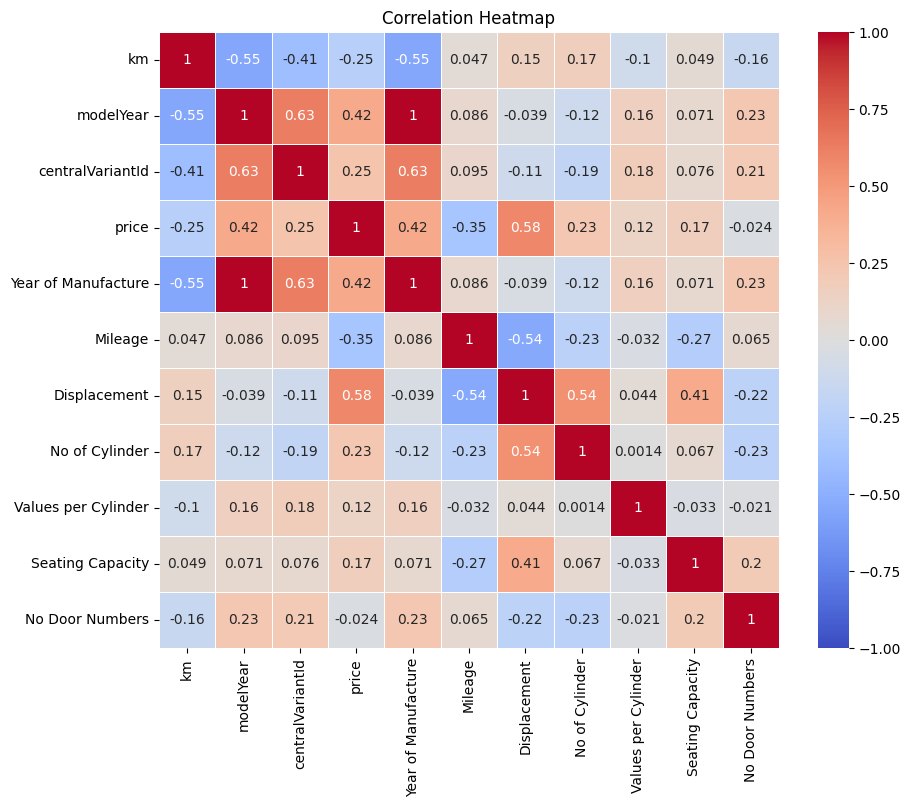

Correlation with 'price':
km                    -0.252182
modelYear              0.420027
centralVariantId       0.253289
price                  1.000000
Year of Manufacture    0.420027
Mileage               -0.347628
Displacement           0.583035
No of Cylinder         0.234110
Values per Cylinder    0.122390
Seating Capacity       0.168242
No Door Numbers       -0.023622
Name: price, dtype: float64


In [30]:
# heatmap for numerical columns

numeric_df = df_cars_zscore_outlier.select_dtypes(include=[float, int])

# Calculate the correlation matrix
correlation_matrix = numeric_df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

# Extract the correlation with 'price'
correlation_with_price = correlation_matrix['price']

# Print the correlation matrix with 'price'
print("Correlation with 'price':")
print(correlation_with_price)

C:\Users\Siva\AppData\Local\Temp\ipykernel_25092\3322647776.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_with_price.index, y=correlation_with_price.values, palette='viridis')


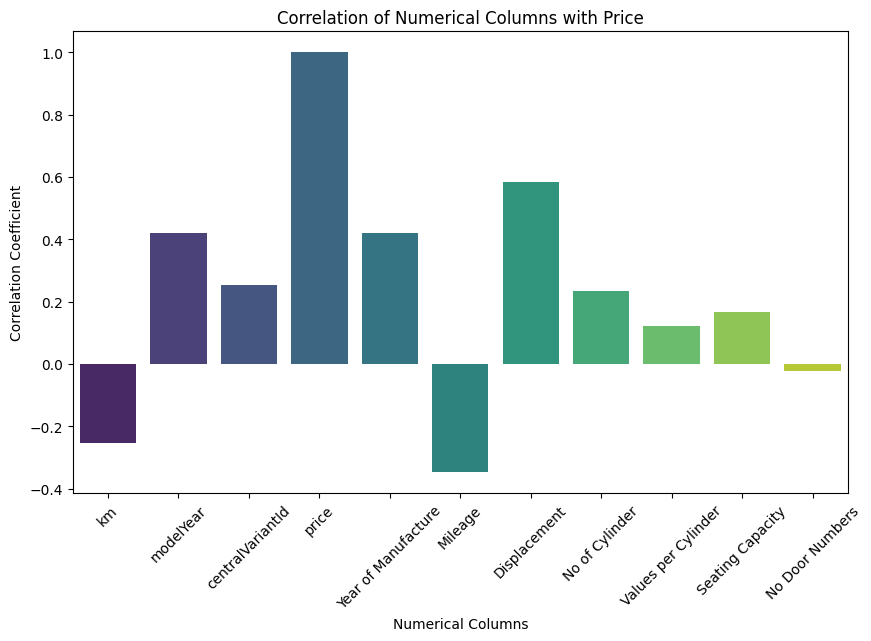

In [31]:
plt.figure(figsize=(10, 6))
sns.barplot(x=correlation_with_price.index, y=correlation_with_price.values, palette='viridis')
plt.title('Correlation of Numerical Columns with Price')
plt.xlabel('Numerical Columns')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45)
plt.show()

#### We can see that km, modelYear, Mileage, Displacement, No of Cylinder, Seating Capacity has a strong co-relation with price, No Door Numbers being close to 0, we can drop No Door Numbers as that we can infer from car model thus we choose values > 0.5 or < -0.5

In [32]:
# dropping columns not required according to co-relation with price

df_cars_zscore_outlier.drop(['No Door Numbers'],axis=1, inplace=True)
df_cars_zscore_outlier.head(1)

,bt,km,oem,model,modelYear,centralVariantId,variantName,price,Registration Year,Insurance Validity,Fuel Type,RTO,Ownership,Transmission,Year of Manufacture,Mileage,Max Power,Torque,Color,Engine Type,Displacement,Max Torque,No of Cylinder,Values per Cylinder,Fuel Suppy System,BoreX Stroke,Compression Ratio,Turbo Charger,Super Charger,Length,Width,Height,Wheel Base,Front Tread,Rear Tread,Kerb Weight,Gross Weight,Gear Box,Drive Type,Seating Capacity,Steering Type,Turning Radius,Front Brake Type,Rear Brake Type,Top Speed,Acceleration,Tyre Type,Cargo Volumn,Wheel Size,Alloy Wheel Size,Ground Clearance Unladen,Location
0,Hatchback,120000.0,Maruti,Maruti Celerio,2015,3979,VXI,400000.0,2015,Third Party insurance,Petrol,KA51,Third Owner,Manual,2015.0,23.1,67.04bhp@6000rpm,90Nm,White,K10B Engine,998.0,90Nm@3500rpm,3.0,4.0,MPFi,73 X 82 mm,11.0:1,No,No,3715mm,1635mm,1565mm,2425mm,1420mm,1410mm,835kg,1250kg,5 Speed,FWD,5.0,Power,4.7 metres,Ventilated Disc,Drum,150 Kmph,15.05 Seconds,"Tubeless, Radial",235-litres,16,16,190mm,Bangalore


## Dealing with Categorical data


In [33]:
df_cars_zscore_outlier.iloc[0]

bt                                      Hatchback
km                                       120000.0
oem                                        Maruti
model                              Maruti Celerio
modelYear                                    2015
centralVariantId                             3979
variantName                                   VXI
price                                    400000.0
Registration Year                            2015
Insurance Validity          Third Party insurance
Fuel Type                                  Petrol
RTO                                          KA51
Ownership                             Third Owner
Transmission                               Manual
Year of Manufacture                        2015.0
Mileage                                      23.1
Max Power                        67.04bhp@6000rpm
Torque                                       90Nm
Color                                       White
Engine Type                           K10B Engine


In [34]:
df_cars_zscore_outlier.isna().sum()

bt                          0
km                          0
oem                         0
model                       0
modelYear                   0
centralVariantId            0
variantName                 0
price                       0
Registration Year           0
Insurance Validity          0
Fuel Type                   0
RTO                         0
Ownership                   0
Transmission                0
Year of Manufacture         0
Mileage                     0
Max Power                   0
Torque                      0
Color                       0
Engine Type                 0
Displacement                0
Max Torque                  0
No of Cylinder              0
Values per Cylinder         0
Fuel Suppy System           0
BoreX Stroke                0
Compression Ratio           0
Turbo Charger               0
Super Charger               0
Length                      0
Width                       0
Height                      0
Wheel Base                  0
Front Trea

### RTO Location column

In [35]:
rto_group_mapping = {
    'KA': 'Karnataka',
    'HR': 'Haryana',
    'WB': 'West Bengal',
    'TN': 'Tamil Nadu',
    'UP': 'Uttar Pradesh',
    'DL': 'Delhi',
    'MH': 'Maharashtra',
    'RJ': 'Rajasthan',
    'AP': 'Andhra Pradesh',
    'GJ': 'Gujarat',
    'OR': 'Odisha',
    'PY': 'Puducherry'
}

# Function to map RTO values
def map_rto(rto):
    if pd.isna(rto):
        return 'Unknown'
    rto_str = str(rto)  # Convert value to string
    for key in rto_group_mapping:
        if rto_str.startswith(key):
            return rto_group_mapping[key]
    return 'Unknown'

# Apply the function to the DataFrame
df_cars_zscore_outlier['RTO_grouped'] = df_cars_zscore_outlier['RTO'].apply(map_rto)
df_cars_zscore_outlier.drop('RTO',axis=1,inplace=True)
df_cars_zscore_outlier.head(1)

,bt,km,oem,model,modelYear,centralVariantId,variantName,price,Registration Year,Insurance Validity,Fuel Type,Ownership,Transmission,Year of Manufacture,Mileage,Max Power,Torque,Color,Engine Type,Displacement,Max Torque,No of Cylinder,Values per Cylinder,Fuel Suppy System,BoreX Stroke,Compression Ratio,Turbo Charger,Super Charger,Length,Width,Height,Wheel Base,Front Tread,Rear Tread,Kerb Weight,Gross Weight,Gear Box,Drive Type,Seating Capacity,Steering Type,Turning Radius,Front Brake Type,Rear Brake Type,Top Speed,Acceleration,Tyre Type,Cargo Volumn,Wheel Size,Alloy Wheel Size,Ground Clearance Unladen,Location,RTO_grouped
0,Hatchback,120000.0,Maruti,Maruti Celerio,2015,3979,VXI,400000.0,2015,Third Party insurance,Petrol,Third Owner,Manual,2015.0,23.1,67.04bhp@6000rpm,90Nm,White,K10B Engine,998.0,90Nm@3500rpm,3.0,4.0,MPFi,73 X 82 mm,11.0:1,No,No,3715mm,1635mm,1565mm,2425mm,1420mm,1410mm,835kg,1250kg,5 Speed,FWD,5.0,Power,4.7 metres,Ventilated Disc,Drum,150 Kmph,15.05 Seconds,"Tubeless, Radial",235-litres,16,16,190mm,Bangalore,Karnataka


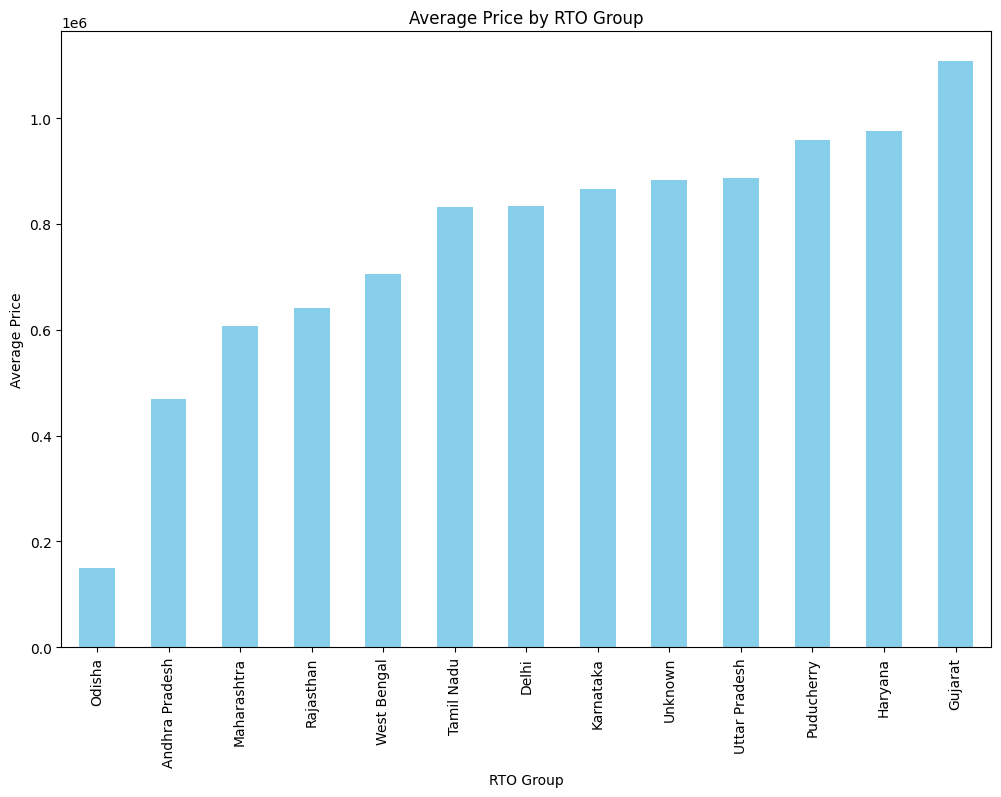

In [36]:
plt.figure(figsize=(12, 8))
average_prices = df_cars_zscore_outlier.groupby('RTO_grouped')['price'].mean().sort_values()
average_prices.plot(kind='bar', color='skyblue')
plt.xticks(rotation=90)
plt.title('Average Price by RTO Group')
plt.xlabel('RTO Group')
plt.ylabel('Average Price')
plt.show()


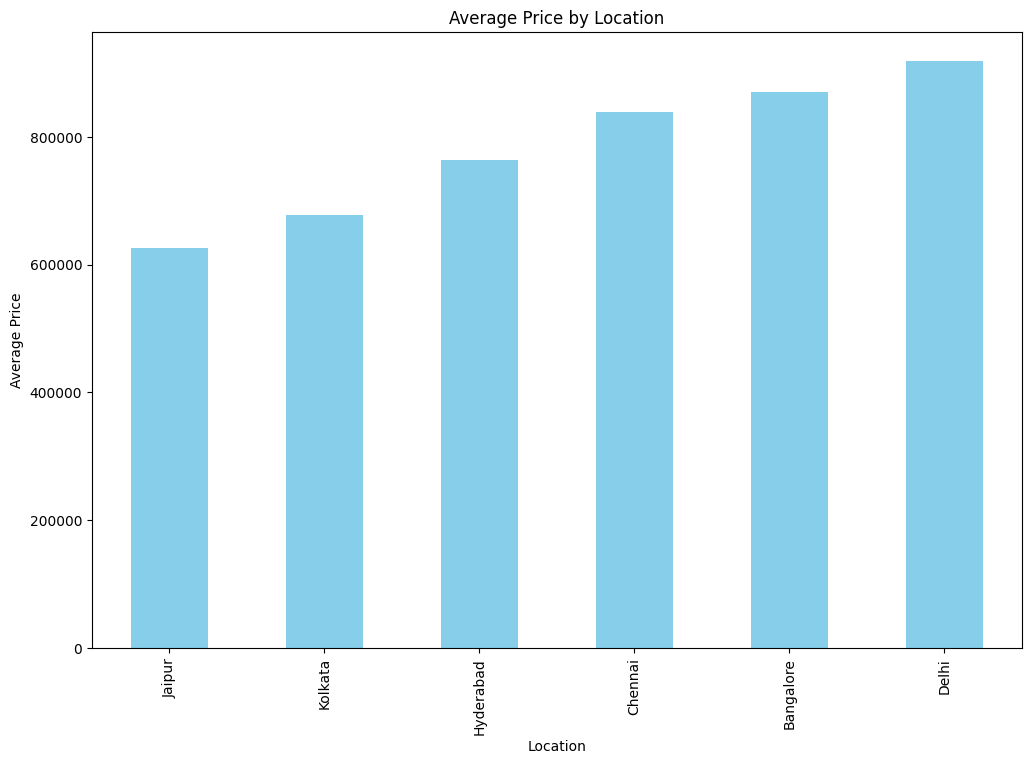

In [37]:
plt.figure(figsize=(12, 8))
average_prices = df_cars_zscore_outlier.groupby('Location')['price'].mean().sort_values()
average_prices.plot(kind='bar', color='skyblue')
plt.xticks(rotation=90)
plt.title('Average Price by Location')
plt.xlabel('Location')
plt.ylabel('Average Price')
plt.show()


### Can keep these two columns RTO_group and Location

## Color Column 

In [38]:
def determine_color(color):
    color_lower = color.lower()
    
    if 'white' in color_lower:
        return 'White'
    elif 'red' in color_lower or 'wine' in color_lower or 'cherry' in color_lower:
        return 'Red'
    elif 'blue' in color_lower:
        return 'Blue'
    elif 'brown' in color_lower:
        return 'Brown'
    elif 'gold' in color_lower:
        return 'Gold'
    elif 'green' in color_lower:
        return 'Green'
    elif 'black' in color_lower:
        return 'Black'     
    elif 'orange' in color_lower:
        return 'Orange'
    elif 'yellow' in color_lower:
        return 'Yellow'
    elif 'bronze' in color_lower:
        return 'Bronze'
    elif 'purple' in color_lower:
        return 'Purple'
    elif 'grey' in color_lower or 'gray' in color_lower:
        return 'Gray'
    elif 'silver' in color_lower or 'metal' in color_lower or 'steel' in color_lower:
        return 'Silver'
    else:
        return 'Other'  # Returns Other if no condition is met

# Apply the function to the DataFrame column
df_cars_zscore_outlier['Color'] = df_cars_zscore_outlier['Color'].apply(determine_color)
df_cars_zscore_outlier['Color'].value_counts()

Color
Other     2092
White     1532
Silver    1254
Red        792
Gray       602
Blue       572
Black      364
Brown      271
Orange     101
Gold        55
Green       39
Yellow      19
Purple       7
Bronze       4
Name: count, dtype: int64

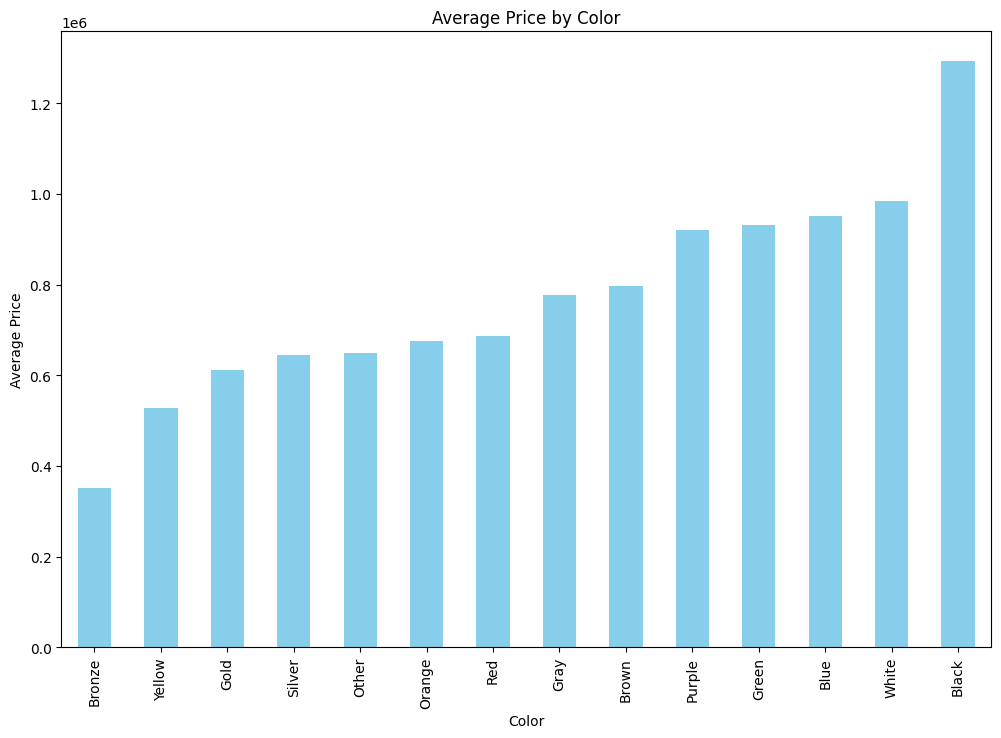

In [39]:
plt.figure(figsize=(12, 8))
average_prices = df_cars_zscore_outlier.groupby('Color')['price'].mean().sort_values()
average_prices.plot(kind='bar', color='skyblue')
plt.xticks(rotation=90)
plt.title('Average Price by Color')
plt.xlabel('Color')
plt.ylabel('Average Price')
plt.show()


### Can keep this column too as price does vary with color 

## Insurance Validity Column 


In [40]:
df_cars_zscore_outlier['Insurance Validity'].unique()


array(['Third Party insurance', 'Comprehensive', 'Third Party',
       'Zero Dep', '2', '1', 'Not Available'], dtype=object)

In [41]:
df_cars_zscore_outlier['Insurance Validity']= df_cars_zscore_outlier['Insurance Validity'].replace('Third Party insurance','Third Party')


In [42]:
df_cars_zscore_outlier['Insurance Validity'].value_counts()

Insurance Validity
Third Party      4318
Comprehensive    2873
Zero Dep          297
Not Available     212
1                   3
2                   1
Name: count, dtype: int64

In [43]:
df_cars_zscore_outlier = df_cars_zscore_outlier[~df_cars_zscore_outlier['Insurance Validity'].isin(['1', '2'])]
df_cars_zscore_outlier['Insurance Validity'].value_counts()

Insurance Validity
Third Party      4318
Comprehensive    2873
Zero Dep          297
Not Available     212
Name: count, dtype: int64

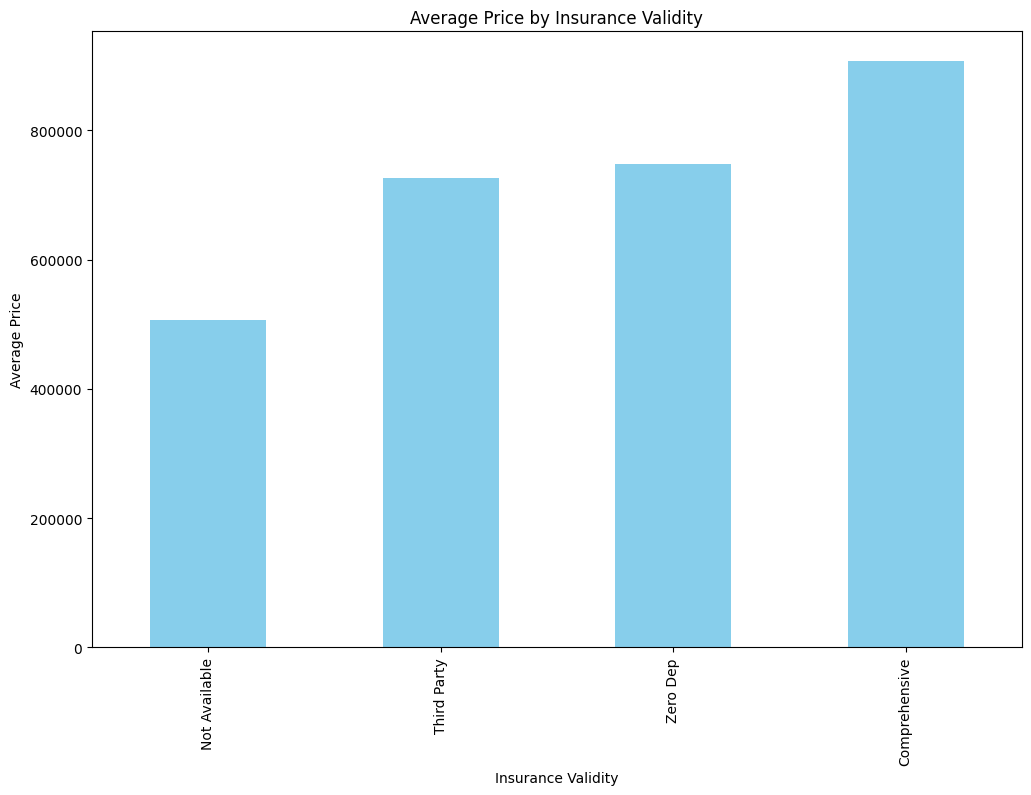

In [44]:
plt.figure(figsize=(12, 8))
average_prices = df_cars_zscore_outlier.groupby('Insurance Validity')['price'].mean().sort_values()
average_prices.plot(kind='bar', color='skyblue')
plt.xticks(rotation=90)
plt.title('Average Price by Insurance Validity')
plt.xlabel('Insurance Validity')
plt.ylabel('Average Price')
plt.show()


### Price does vary as thus we retain the Insurance Column

## Engine Type Column

In [45]:
print(df_cars_zscore_outlier['Engine Type'].head())
print(df_cars_zscore_outlier['Engine Type'].isna().sum())
print(df_cars_zscore_outlier['Engine Type'].value_counts())

0                 K10B Engine
1        Ti-VCT Petrol Engine
2             Revotron Engine
3    Kappa VTVT Petrol Engine
4      DDiS 200 Diesel Engine
Name: Engine Type, dtype: object
0
Engine Type
In-Line Engine               640
Kappa VTVT Petrol Engine     424
Petrol Engine                305
i-VTEC Petrol Engine         266
i VTEC Engine                199
                            ... 
GDi Petrol Engine              1
2-TR-FE Dual VVT-i Engine      1
1.1 L Bi-Fuel                  1
mFALCON G80                    1
TDI Engine                     1
Name: count, Length: 434, dtype: int64


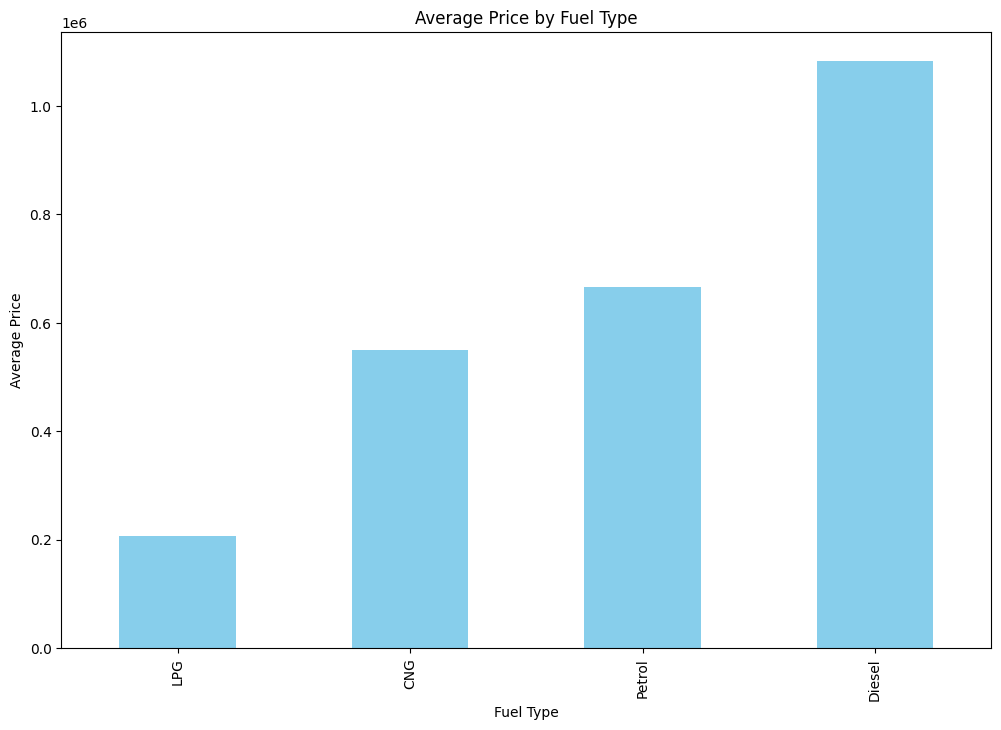

In [46]:
plt.figure(figsize=(12, 8))
average_prices = df_cars_zscore_outlier.groupby('Fuel Type')['price'].mean().sort_values()
average_prices.plot(kind='bar', color='skyblue')
plt.xticks(rotation=90)
plt.title('Average Price by Fuel Type')
plt.xlabel('Fuel Type')
plt.ylabel('Average Price')
plt.show()


In [47]:
#combining cng and lpg to gas 
df_cars_zscore_outlier['Fuel Type']= df_cars_zscore_outlier['Fuel Type'].replace('Cng','Gas')
df_cars_zscore_outlier['Fuel Type']= df_cars_zscore_outlier['Fuel Type'].replace('Lpg','Gas')


## oem, model, and variant name columns

In [48]:
print('Null values(oem):',df_cars_zscore_outlier['oem'].isna().sum())
print('unique elements and its occurance(oem):',df_cars_zscore_outlier['oem'].value_counts())
print('no. of unique elements (oem):',df_cars_zscore_outlier['oem'].nunique())

print('\nNull values(model):',df_cars_zscore_outlier['model'].isna().sum())
print('unique elements and its occurance(model):',df_cars_zscore_outlier['model'].value_counts())
print('no. of unique elements(model):',df_cars_zscore_outlier['model'].nunique())

print('\nNull values(variantName):',df_cars_zscore_outlier['variantName'].isna().sum())
print('unique elements and its occurance(variantName):',df_cars_zscore_outlier['variantName'].value_counts())
print('no. of unique elements(variantName)',df_cars_zscore_outlier['variantName'].nunique())


Null values(oem): 0
unique elements and its occurance(oem): oem
Maruti                2164
Hyundai               1626
Honda                  852
Tata                   395
Renault                309
Mahindra               302
Volkswagen             286
Ford                   283
Toyota                 207
Kia                    155
Skoda                  155
Mercedes-Benz          151
Audi                   128
BMW                    119
Jeep                   108
MG                      83
Nissan                  78
Datsun                  74
Chevrolet               72
Volvo                   37
Fiat                    30
Jaguar                  25
Land Rover              22
Mitsubishi               9
Citroen                  8
Mini                     7
Mahindra Renault         5
Mahindra Ssangyong       4
Lexus                    2
Hindustan Motors         2
Isuzu                    2
Name: count, dtype: int64
no. of unique elements (oem): 31

Null values(model): 0
unique elements a

In [ ]:
df_cars_zscore_outlier.shape


(7700, 52)

# Fuel Supply System Column

In [50]:
print(df_cars_zscore_outlier['Fuel Suppy System'].value_counts())
print(df_cars_zscore_outlier['Fuel Suppy System'].unique())
print(df_cars_zscore_outlier['Fuel Suppy System'].nunique())
print(df_cars_zscore_outlier['Fuel Suppy System'].isna().sum())

Fuel Suppy System
MPFI                          3553
MPFi                           811
CRDi                           801
CRDI                           738
Direct Injection               627
                              ... 
EFi                              1
Multi point Fuel Injection       1
Dual VVT-i                       1
IDI                              1
Direct Injectio                  1
Name: count, Length: 68, dtype: int64
['MPFi' 'Direct Injection' 'MPFI' 'CRDI' 'Electronic Injection System'
 'GDi' 'PGM - Fi' 'Direct Injection ' 'PGM-Fi' 'CRDi'
 'Multi Point Fuel Injection' 'MPFI+LPG'
 'Common Rail Direct Injection (dCi)' 'Multipoint Injection' 'CDI' 'PFI'
 'EFI(Electronic Fuel Injection)' 'MPFI ' 'EFI' 'Multi-point injection'
 'TSI' 'Common rail direct injection' 'PGM-FI (Programmed Fuel Injection)'
 'Electronic Fuel Injection' 'Common Rail Direct Injection' 'Common Rail'
 'SEFI' 'Multi point Fuel Injection' 'MPI' 'Gasoline Direct Injection'
 'MPi' 'Dual VVT-i' 'SMPI' '

## Turbo charger and Super Charge

In [51]:
print(df_cars_zscore_outlier['Turbo Charger'].value_counts())
print(df_cars_zscore_outlier['Turbo Charger'].unique())
print(df_cars_zscore_outlier['Turbo Charger'].nunique())
print(df_cars_zscore_outlier['Turbo Charger'].isna().sum())
print('\n',df_cars_zscore_outlier['Super Charger'].value_counts())
print(df_cars_zscore_outlier['Super Charger'].unique())
print(df_cars_zscore_outlier['Super Charger'].nunique())
print(df_cars_zscore_outlier['Super Charger'].isna().sum())

Turbo Charger
No       5023
Yes      2608
Twin       23
NO         20
YES        15
no          9
Turbo       1
yes         1
Name: count, dtype: int64
['No' 'Yes' 'NO' 'Twin' 'YES' 'no' 'Turbo' 'yes']
8
0

 Super Charger
No     7685
Yes      11
NO        2
no        1
yes       1
Name: count, dtype: int64
['No' 'Yes' 'NO' 'no' 'yes']
5
0


In [52]:
mapping = {
    'No':False,
    'NO':False,
    'no':False,
    None:False,

    'Yes':True,
    'YES':True,
    'yes':True,
    'Turbo':True,
    'Twin':True,
}
df_cars_zscore_outlier['Turbo Charger'] = df_cars_zscore_outlier['Turbo Charger'].map(mapping).fillna(False)

print(df_cars_zscore_outlier['Turbo Charger'].value_counts())
print(df_cars_zscore_outlier['Turbo Charger'].unique())
print(df_cars_zscore_outlier['Turbo Charger'].nunique())
print(df_cars_zscore_outlier['Turbo Charger'].isna().sum())
print(df_cars_zscore_outlier['Turbo Charger'].dtype)



Turbo Charger
False    5052
True     2648
Name: count, dtype: int64
[False  True]
2
0
bool


In [53]:
mapping = {
    'No':False,
    'NO':False,
    'no':False,

    'Yes':True,
    
}
df_cars_zscore_outlier['Super Charger'] = df_cars_zscore_outlier['Super Charger'].map(mapping).fillna(False)

print(df_cars_zscore_outlier['Super Charger'].value_counts())
print(df_cars_zscore_outlier['Super Charger'].unique())
print(df_cars_zscore_outlier['Super Charger'].nunique())
print(df_cars_zscore_outlier['Super Charger'].isna().sum())
print(df_cars_zscore_outlier['Super Charger'].dtype)



Super Charger
False    7689
True       11
Name: count, dtype: int64
[False  True]
2
0
bool


C:\Users\Siva\AppData\Local\Temp\ipykernel_25092\1354746950.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_cars_zscore_outlier['Super Charger'] = df_cars_zscore_outlier['Super Charger'].map(mapping).fillna(False)


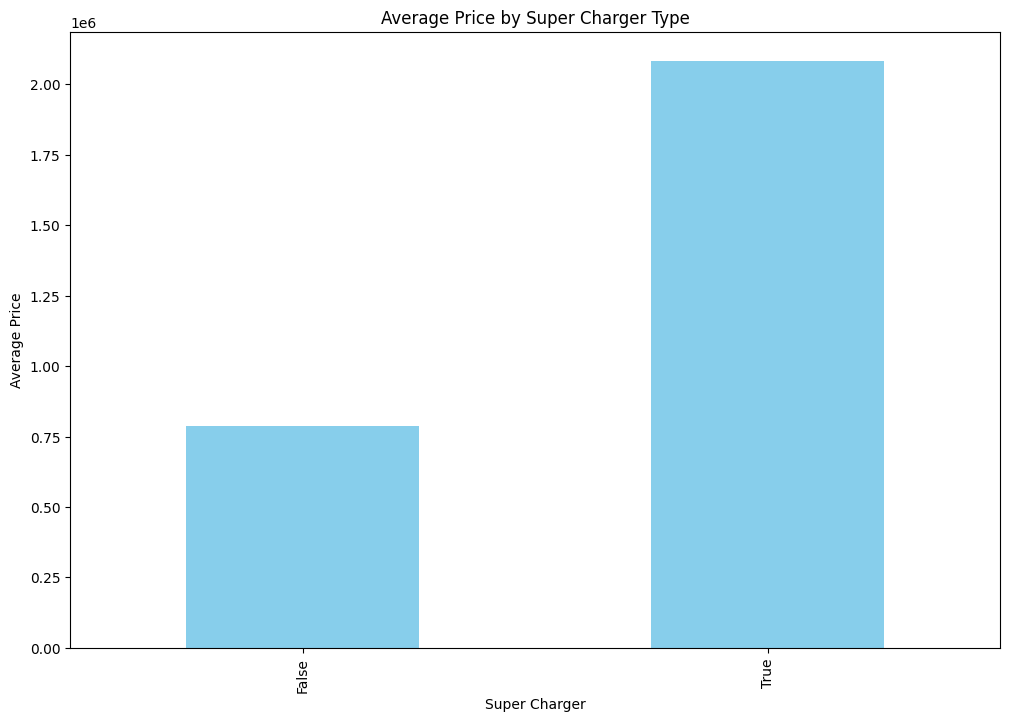

In [54]:
plt.figure(figsize=(12, 8))
average_prices = df_cars_zscore_outlier.groupby('Super Charger')['price'].mean().sort_values()
average_prices.plot(kind='bar', color='skyblue')
plt.xticks(rotation=90)
plt.title('Average Price by Super Charger Type')
plt.xlabel('Super Charger')
plt.ylabel('Average Price')
plt.show()


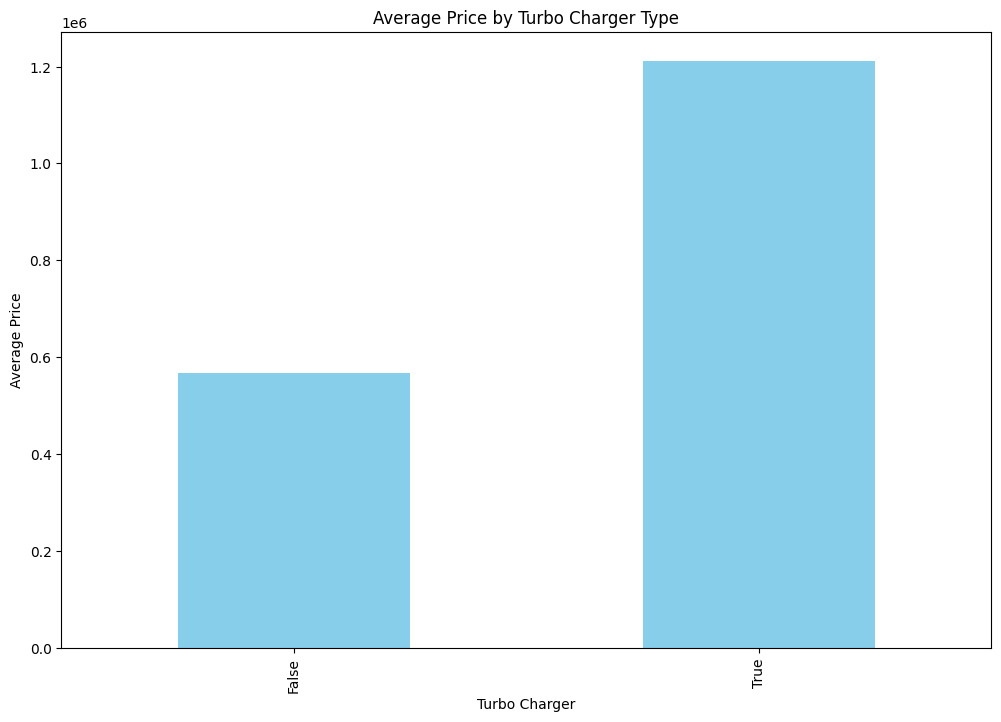

In [56]:
plt.figure(figsize=(12, 8))
average_prices = df_cars_zscore_outlier.groupby('Turbo Charger')['price'].mean().sort_values()
average_prices.plot(kind='bar', color='skyblue')
plt.xticks(rotation=90)
plt.title('Average Price by Turbo Charger Type')
plt.xlabel('Turbo Charger')
plt.ylabel('Average Price')
plt.show()


## Gear Box column

In [57]:
print(df_cars_zscore_outlier['Gear Box'].value_counts())
print(df_cars_zscore_outlier['Gear Box'].nunique())
print(df_cars_zscore_outlier['Gear Box'].unique())
print(df_cars_zscore_outlier['Gear Box'].isna().sum())

Gear Box
5 Speed             4316
6 Speed              955
5-Speed              532
6-Speed              231
7 Speed              226
                    ... 
Six Speed Manual       1
7-speed                1
6 Speed MT             1
6Speed                 1
10 speed               1
Name: count, Length: 92, dtype: int64
92
['5 Speed ' '5 Speed' '6 Speed' '7-Speed' '4 Speed' '6 Speed ' '5-Speed'
 '9 Speed' '8 Speed' '8-Speed Steptronic' '6-Speed' '7 Speed'
 '7-Speed DCT' '5' '6 Speed IMT' '6-speed AutoSHIFT' '6-speed CVT' 'CVT'
 '6-speed' '7-speed DCT' '7 Speed DSG' '7 Speed DCT' '6' '8-Speed'
 '5-speed' '6 speed ' '5 speed' '7 Speed CVT' 'Five Speed Manual'
 '5 Speed CVT' '6-Speed iMT' '6-Speed DCT' '7-Speed S-Tronic '
 '7G DCT 7-Speed Dual Clutch Transmission ' '7-Speed S-Tronic' '5-Speed`'
 '6-Speed IVT' '6 Speed IVT' 'IVT' '8 Speed CVT'
 'Five Speed Manual Transmission' '5 Speed AT+ Paddle Shifters' '8-Speed '
 'iMT' 'AGS' '6Speed' '4-Speed' '9-Speed' '6-Speed IMT' '6 Speed MT'
 'Fi

### We can use the automatic and manual for our calculation instead of gearbox

In [58]:
df_cars_zscore_outlier.drop('Gear Box',axis=1,inplace= True)

## Drive Type Column

In [59]:
df_cars_zscore_outlier['Drive Type'] = df_cars_zscore_outlier['Drive Type'].replace({
    # Front-Wheel Drive
    'FWD': 'Front-Wheel Drive (FWD)',
    'FWD ': 'Front-Wheel Drive (FWD)',
    'Front Wheel Drive': 'Front-Wheel Drive (FWD)',
    
    # Rear-Wheel Drive
    'RWD': 'Rear-Wheel Drive (RWD)',
    'Rear Wheel Drive with ESP': 'Rear-Wheel Drive (RWD)',
    'RWD(with MTT)': 'Rear-Wheel Drive (RWD)',
    
    # All-Wheel Drive
    'AWD': 'All-Wheel Drive (AWD)',
    'All Wheel Drive': 'All-Wheel Drive (AWD)',
    'Permanent all-wheel drive quattro': 'All-Wheel Drive (AWD)',
    'AWD INTEGRATED MANAGEMENT': 'All-Wheel Drive (AWD)',
    
    # Four-Wheel Drive
    '4WD': 'Four-Wheel Drive (4WD)',
    '4 WD': 'Four-Wheel Drive (4WD)',
    '4X4': 'Four-Wheel Drive (4WD)',
    '4x4': 'Four-Wheel Drive (4WD)',
    
    # Two-Wheel Drive
    '2WD': 'Front-Wheel Drive (FWD)',
    '2WD ': 'Front-Wheel Drive (FWD)',
    '2 WD': 'Front-Wheel Drive (FWD)',
    '4X2': 'Two-Wheel Drive (2WD)',
    '4x2': 'Two-Wheel Drive (2WD)',
    'Two Wheel Drive': 'Two-Wheel Drive (2WD)',
    
   })

df_cars_zscore_outlier['Drive Type']=df_cars_zscore_outlier['Drive Type'].fillna('Undefined')
print(df_cars_zscore_outlier['Drive Type'].value_counts())
print(df_cars_zscore_outlier['Drive Type'].isna().sum())

Drive Type
Front-Wheel Drive (FWD)    7044
Rear-Wheel Drive (RWD)      298
All-Wheel Drive (AWD)       173
Two-Wheel Drive (2WD)       100
Four-Wheel Drive (4WD)       85
Name: count, dtype: int64
0


## Steering Type Column

In [60]:
print(df_cars_zscore_outlier['Steering Type'].value_counts())
print(df_cars_zscore_outlier['Steering Type'].nunique())
print(df_cars_zscore_outlier['Steering Type'].unique())
print(df_cars_zscore_outlier['Steering Type'].isna().sum())


Steering Type
Power         6088
Electric      1370
Electronic     102
Manual          61
Electrical      41
power           29
EPAS             9
Name: count, dtype: int64
7
['Power' 'power' 'Electric' 'EPAS' 'Electrical' 'Electronic' 'Manual']
0


In [61]:
df_cars_zscore_outlier['Steering Type'] = df_cars_zscore_outlier['Steering Type'].replace({
    # Combined Power Systems
    'Power': 'Power',
    'power': 'Power',
    'Electric': 'Power',
    'electric': 'Power',
    'Electronic': 'Power', 
    'Electrical': 'Power', 
    'EPAS': 'Power',
    # Specific Steering Types
    'Manual': 'Manual',
    
})
print(df_cars_zscore_outlier['Steering Type'].value_counts())


Steering Type
Power     7639
Manual      61
Name: count, dtype: int64


### Front Brake and rear brake Type Column

In [62]:
print(df_cars_zscore_outlier['Front Brake Type'].value_counts())
print(df_cars_zscore_outlier['Front Brake Type'].nunique())
print(df_cars_zscore_outlier['Front Brake Type'].unique())
print('\n',df_cars_zscore_outlier['Rear Brake Type'].value_counts())
print(df_cars_zscore_outlier['Rear Brake Type'].nunique())
print(df_cars_zscore_outlier['Rear Brake Type'].unique())

Front Brake Type
Disc                                        5050
Ventilated Disc                             2307
Disc                                          70
Solid Disc                                    63
Ventilated Discs                              55
Disc & Caliper Type                           40
Ventilated Disc                               23
Disk                                          23
Ventilated Disk                               11
disc                                           7
Multilateral Disc                              6
Ventlated Disc                                 6
Ventilated discs                               6
 Disc                                          6
Vantilated Disc                                6
Ventilated DIsc                                5
Ventillated Disc                               3
Vacuum assisted hydraulic dual circuit w       2
 Ventilated Disc                               2
Booster assisted ventilated disc               2
ven

### Tyre Type Column

In [63]:
print(df_cars_zscore_outlier['Tyre Type'].value_counts())
print(df_cars_zscore_outlier['Tyre Type'].nunique())
print(df_cars_zscore_outlier['Tyre Type'].unique())

Tyre Type
Tubeless,Radial           4068
Tubeless, Radial          1346
Tubeless                  1143
Tubeless Tyres             407
Radial, Tubeless           195
Radial                     120
Radial, Tubless             82
Tubeless,Radial             54
Tubeless Tyres, Radial      54
Tubeless Radial Tyres       51
Radial,Tubeless             44
Tubeless,Radials            32
Tubless, Radial             26
tubeless tyre               14
Runflat                     12
Run-Flat                    12
Tubeless, Runflat            7
Tubeless                     7
Tubeless,Runflat             6
Radial Tubeless              5
Runflat Tyres                3
Tubeless Radials Tyre        3
Radial with tube             2
Tubeless Tyre                2
Tubless,Radial               1
Radial Tyres                 1
Tubeless, Radials            1
Tubeless Radial              1
Radial                       1
Name: count, dtype: int64
29
['Tubeless, Radial' 'Tubeless,Radial' 'Tubeless' 'Radial, Tubl

In [64]:
df_cars_zscore_outlier.head()

,bt,km,oem,model,modelYear,centralVariantId,variantName,price,Registration Year,Insurance Validity,Fuel Type,Ownership,Transmission,Year of Manufacture,Mileage,Max Power,Torque,Color,Engine Type,Displacement,Max Torque,No of Cylinder,Values per Cylinder,Fuel Suppy System,BoreX Stroke,Compression Ratio,Turbo Charger,Super Charger,Length,Width,Height,Wheel Base,Front Tread,Rear Tread,Kerb Weight,Gross Weight,Drive Type,Seating Capacity,Steering Type,Turning Radius,Front Brake Type,Rear Brake Type,Top Speed,Acceleration,Tyre Type,Cargo Volumn,Wheel Size,Alloy Wheel Size,Ground Clearance Unladen,Location,RTO_grouped
0,Hatchback,120000.0,Maruti,Maruti Celerio,2015,3979,VXI,400000.0,2015,Third Party,Petrol,Third Owner,Manual,2015.0,23.10,67.04bhp@6000rpm,90Nm,White,K10B Engine,998.0,90Nm@3500rpm,3.0,4.0,MPFi,73 X 82 mm,11.0:1,False,False,3715mm,1635mm,1565mm,2425mm,1420mm,1410mm,835kg,1250kg,Front-Wheel Drive (FWD),5.0,Power,4.7 metres,Ventilated Disc,Drum,150 Kmph,15.05 Seconds,"Tubeless, Radial",235-litres,16,16,190mm,Bangalore,Karnataka
1,SUV,32706.0,Ford,Ford Ecosport,2018,6087,1.5 Petrol Titanium BSIV,811000.0,Feb 2018,Comprehensive,Petrol,Second Owner,Manual,2018.0,17.00,121.31bhp@6500rpm,150Nm,White,Ti-VCT Petrol Engine,1497.0,150Nm@4500rpm,3.0,4.0,Direct Injection,79 X 76.5 mm,11.0:1,False,False,3998mm,1765mm,1647mm,2519mm,1295mm,1290mm,1242Kg,1660Kg,Front-Wheel Drive (FWD),5.0,Power,5.3 metres,Ventilated Disc,Drum,165 Kmph,10 Seconds,"Tubeless,Radial",352-litres,16,16,190mm,Bangalore,Karnataka
2,Hatchback,11949.0,Tata,Tata Tiago,2018,2983,1.2 Revotron XZ,585000.0,Sept 2018,Comprehensive,Petrol,First Owner,Manual,2018.0,23.84,84bhp@6000rpm,114Nm,Red,Revotron Engine,1199.0,114Nm@3500rpm,3.0,4.0,MPFi,77 X 85.8 mm,10.8:1,False,False,3746mm,1647mm,1535mm,2400mm,1400mm,1420mm,1012kg,1340kg,Front-Wheel Drive (FWD),5.0,Power,4.9 meters,Disc,Drum,150 kmph,14.3 Seconds,Tubeless,242-litres,14,14,190mm,Bangalore,Karnataka
3,Sedan,17794.0,Hyundai,Hyundai Xcent,2014,1867,1.2 Kappa S Option,462000.0,Dec 2014,Comprehensive,Petrol,First Owner,Manual,2014.0,19.10,81.86bhp@6000rpm,113.75Nm,Other,Kappa VTVT Petrol Engine,1197.0,113.75Nm@4000rpm,4.0,4.0,Direct Injection,73.0 X 89.4 mm,10.5:1,False,False,3995mm,1660mm,1520mm,2425mm,1479mm,1493mm,1180,1340kg,Front-Wheel Drive (FWD),5.0,Power,4.7 metres,Disc,Drum,172km/hr,14.2 Seconds,"Tubeless,Radial",407-litres,14,14,190mm,Bangalore,Karnataka
4,SUV,60000.0,Maruti,Maruti SX4 S Cross,2015,4277,DDiS 200 Zeta,790000.0,2015,Third Party,Diesel,First Owner,Manual,2015.0,23.65,88.5bhp@4000rpm,200Nm,Gray,DDiS 200 Diesel Engine,1248.0,200Nm@1750rpm,4.0,4.0,MPFI,69.6 x 82 mm,10.5:1,True,False,4300mm,1785mm,1595mm,2600mm,1295mm,1290mm,1230Kg,1670kg,Front-Wheel Drive (FWD),5.0,Power,5.2 meters,Ventilated Disc,Solid Disc,190 Kmph,12 Seconds,"Tubeless,Radial",353-litres,16,16,190mm,Bangalore,Karnataka


In [65]:
## saving this file as an excel for further use

df_cars_zscore_outlier.to_excel('all_cities_cars_cleaned.xlsx', index=False)


## 4. Model Training 

In [66]:
import pandas as pd
from sklearn.model_selection import train_test_split

df_cars_final = pd.read_excel('all_cities_cars_cleaned.xlsx')

categorical_features = df_cars_final.select_dtypes(include=['object']).columns
numerical_features = df_cars_final.select_dtypes(include=['number']).columns

# Separate the target variable
X = df_cars_final.drop('price', axis=1)
y = df_cars_final['price']

# Apply one-hot encoding to categorical features
X_encoded = pd.get_dummies(X, columns=categorical_features, drop_first=True)

# The numerical columns are automatically included as they are

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

print(f"Training feature set shape: {X_train.shape}")
print(f"Testing feature set shape: {X_test.shape}")


Training feature set shape: (6160, 8083)
Testing feature set shape: (1540, 8083)


In [67]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

# Define the models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'XGBoost': XGBRegressor()
}

# Store the results
results = {}

# Evaluate each model
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics for training set
    results[model_name] = {
        'MSE_train': mean_squared_error(y_train, y_train_pred),
        'MAE_train': mean_absolute_error(y_train, y_train_pred),
        'R2_train': r2_score(y_train, y_train_pred),
        'MAPE_train': mean_absolute_percentage_error(y_train, y_train_pred) * 100,
        'MSE_test': mean_squared_error(y_test, y_test_pred),
        'MAE_test': mean_absolute_error(y_test, y_test_pred),
        'R2_test': r2_score(y_test, y_test_pred),
        'MAPE_test': mean_absolute_percentage_error(y_test, y_test_pred) * 100
    }

# Convert results to DataFrame and reorder columns
results_df = pd.DataFrame(results).T
results_df = results_df[['MSE_train', 'MAE_train', 'R2_train', 'MAPE_train', 
                          'MSE_test', 'MAE_test', 'R2_test', 'MAPE_test']]
print(results_df)


                      MSE_train     MAE_train  R2_train  MAPE_train  \
Linear Regression  1.129491e+10  52570.874386  0.977979    8.722966   
Decision Tree      1.437293e+08    472.564935  0.999720    0.047023   
Random Forest      4.726714e+09  34955.013327  0.990785    5.084049   
XGBoost            5.321369e+09  51646.055139  0.989625    9.382286   

                       MSE_test      MAE_test       R2_test     MAPE_test  
Linear Regression  2.204207e+22  3.360968e+10 -4.495937e+10  5.799831e+06  
Decision Tree      4.866186e+10  1.176287e+05  9.007440e-01  1.711835e+01  
Random Forest      3.419047e+10  9.738631e+04  9.302614e-01  1.386501e+01  
XGBoost            2.663608e+10  8.818056e+04  9.456702e-01  1.291238e+01  


## The best models are Random Forest and XGBoost with R2 scores as 0.93 and 0.94

### Attempting to hypertune the parameters 

In [68]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from scipy.stats import uniform

# Define hyperparameters for Random Forest
param_distributions_rf = {
    'n_estimators': [300],
    'max_depth': [30],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}

# Initialize Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Perform Randomized Search CV
rf_random_search = RandomizedSearchCV(
    rf_model,
    param_distributions=param_distributions_rf,
    n_iter=50,
    scoring='neg_mean_absolute_percentage_error',
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Fit the model on the training data
rf_random_search.fit(X_train, y_train)

# Retrieve the best parameters
best_rf_params = rf_random_search.best_params_
print(f"Best Random Forest Parameters: {best_rf_params}")

# Initialize the model with the best parameters
rf_model = RandomForestRegressor(
    n_estimators=best_rf_params['n_estimators'], 
    max_depth=best_rf_params['max_depth'], 
    min_samples_split=best_rf_params['min_samples_split'], 
    min_samples_leaf=best_rf_params['min_samples_leaf'],
    random_state=42
)

# Train the model on the training data
rf_model.fit(X_train, y_train)

# Make predictions on the training set
y_train_pred_rf = rf_model.predict(X_train)

# Calculate metrics for the training set
mse_train_rf = mean_squared_error(y_train, y_train_pred_rf)
r2_train_rf = r2_score(y_train, y_train_pred_rf)
mape_train_rf = mean_absolute_percentage_error(y_train, y_train_pred_rf) * 100

# Print metrics for the training set
print(f"Random Forest Train MSE: {mse_train_rf}")
print(f"Random Forest Train R^2: {r2_train_rf}")
print(f"Random Forest Train MAPE: {mape_train_rf}%")

# Make predictions on the test set
y_test_pred_rf = rf_model.predict(X_test)

# Calculate metrics for the test set
mse_test_rf = mean_squared_error(y_test, y_test_pred_rf)
r2_test_rf = r2_score(y_test, y_test_pred_rf)
mape_test_rf = mean_absolute_percentage_error(y_test, y_test_pred_rf) * 100

# Print metrics for the test set
print(f"Random Forest Test MSE: {mse_test_rf}")
print(f"Random Forest Test R^2: {r2_test_rf}")
print(f"Random Forest Test MAPE: {mape_test_rf}%")


c:\Users\Siva\miniconda3\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 1 is smaller than n_iter=50. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Random Forest Parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30}
Random Forest Train MSE: 4484901179.437211
Random Forest Train R^2: 0.9912560761167712
Random Forest Train MAPE: 5.021594007675137%
Random Forest Test MSE: 34377407673.8792
Random Forest Test R^2: 0.9298801490208533
Random Forest Test MAPE: 13.91420632595616%


In [69]:
# Import necessary libraries
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

# Define hyperparameter distribution for RandomizedSearchCV
param_distributions_xgb = {
    'n_estimators': [300],
    'max_depth': [5],
    'learning_rate': [0.1],
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'alpha': [0.5],
    'lambda': [0]
}

# Initialize XGBoost model
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

# Perform RandomizedSearchCV for hyperparameter tuning
xgb_random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_distributions_xgb,
    n_iter=50,
    scoring='neg_mean_absolute_percentage_error',
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Fit RandomizedSearchCV
xgb_random_search.fit(X_train, y_train)

# Get the best parameters from RandomizedSearchCV
best_xgb_params = xgb_random_search.best_params_
print(f"Best XGBoost Parameters: {best_xgb_params}")

# Initialize and train the XGBoost model with the best parameters
xgb_model = XGBRegressor(
    alpha=best_xgb_params['alpha'], 
    colsample_bytree=best_xgb_params['colsample_bytree'], 
    lambda_=best_xgb_params['lambda'], 
    learning_rate=best_xgb_params['learning_rate'], 
    max_depth=best_xgb_params['max_depth'], 
    n_estimators=best_xgb_params['n_estimators'], 
    subsample=best_xgb_params['subsample'], 
    objective='reg:squarederror',
    random_state=42
)

# Fit the XGBoost model to the training data
xgb_model.fit(X_train, y_train)

# Make predictions on training data
y_train_pred_xgb = xgb_model.predict(X_train)

# Calculate metrics for training data
mse_train_xgb = mean_squared_error(y_train, y_train_pred_xgb)
r2_train_xgb = r2_score(y_train, y_train_pred_xgb)
mape_train_xgb = mean_absolute_percentage_error(y_train, y_train_pred_xgb) * 100

# Print training metrics
print(f"XGBoost Train MSE: {mse_train_xgb}")
print(f"XGBoost Train R^2: {r2_train_xgb}")
print(f"XGBoost Train MAPE: {mape_train_xgb}%")

# Make predictions on test data
y_test_pred_xgb = xgb_model.predict(X_test)

# Calculate metrics for test data
mse_test_xgb = mean_squared_error(y_test, y_test_pred_xgb)
r2_test_xgb = r2_score(y_test, y_test_pred_xgb)
mape_test_xgb = mean_absolute_percentage_error(y_test, y_test_pred_xgb) * 100

# Print test metrics
print(f"XGBoost Test MSE: {mse_test_xgb}")
print(f"XGBoost Test R^2: {r2_test_xgb}")
print(f"XGBoost Test MAPE: {mape_test_xgb}%")


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best XGBoost Parameters: {'alpha': 0.5, 'colsample_bytree': 0.5372753218398854, 'lambda': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.9934434683002586}


c:\Users\Siva\miniconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:41:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "lambda_" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Train MSE: 7022268225.997216
XGBoost Train R^2: 0.9863091344939198
XGBoost Train MAPE: 10.603307219475646%
XGBoost Test MSE: 24249761283.22087
XGBoost Test R^2: 0.9505375837646035
XGBoost Test MAPE: 12.9630509953021%


### XGBoost Performs the best after best parameters fit  with R2 score of 0.95

## Before finalizing let us utilize Lasso and Ridge regularization to our model to see if performance metrics is better

In [70]:
from sklearn.linear_model import Ridge, Lasso

models = {
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
}
# Store the results
results = {}

# Evaluate each model
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    mse_train = mean_squared_error(y_train, y_train_pred)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    r2_train = r2_score(y_train, y_train_pred)
    mape_train = mean_absolute_percentage_error(y_train, y_train_pred) * 100
    
    mse_test = mean_squared_error(y_test, y_test_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)
    mape_test = mean_absolute_percentage_error(y_test, y_test_pred) * 100
    
    # Store the results
    results[model_name] = {
        'MSE_train': mse_train,
        'MAE_train': mae_train,
        'R2_train': r2_train,
        'MAPE_train': mape_train,
        'MSE_test': mse_test,
        'MAE_test':mae_test,
        'R2_test': r2_test,
        'MAPE_test': mape_test
    }

# Convert results to DataFrame
results_df = pd.DataFrame(results).T
print(results_df)


c:\Users\Siva\miniconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.673e+13, tolerance: 3.160e+11
  model = cd_fast.enet_coordinate_descent(


                     MSE_train     MAE_train  R2_train  MAPE_train  \
Ridge Regression  1.234710e+10  60914.829711  0.975928   10.323485   
Lasso Regression  1.134227e+10  53571.948494  0.977887    9.036075   

                      MSE_test       MAE_test   R2_test  MAPE_test  
Ridge Regression  3.741272e+10  106499.378052  0.923689  17.434194  
Lasso Regression  4.621099e+10  115098.957433  0.905743  18.123189  


### Seems like XGBoost Performs the best and thus we choose that model for the application

# 5. Saving model

In [71]:
import joblib

# Save the model
joblib.dump(xgb_model, 'xgboost_model.pkl')
joblib.dump(rf_model, 'rf_model.pkl')


['rf_model.pkl']

In [72]:
# Save column names for encoding
encoded_columns = list(X_encoded.columns)
joblib.dump(encoded_columns, 'encoded_columns.pkl')

['encoded_columns.pkl']

# 6. Saving Car brand images url for display purposes

In [73]:
import pandas as pd
df_cars_final = pd.read_excel('all_cities_cars_cleaned.xlsx')


In [74]:
df_cars_final['url_model'] = ""

In [75]:
df_cars_final['oem'].unique()

array(['Maruti', 'Ford', 'Tata', 'Hyundai', 'Jeep', 'Datsun', 'Honda',
       'Mahindra', 'BMW', 'Renault', 'Mercedes-Benz', 'Audi', 'Kia',
       'Skoda', 'Volkswagen', 'Volvo', 'MG', 'Toyota', 'Nissan', 'Fiat',
       'Mahindra Ssangyong', 'Mitsubishi', 'Jaguar', 'Land Rover',
       'Chevrolet', 'Citroen', 'Mahindra Renault', 'Mini', 'Lexus',
       'Hindustan Motors', 'Isuzu'], dtype=object)

In [76]:
df_cars_final.loc[df_cars_final['oem'] == 'Maruti', 'url_model'] = 'https://logos-world.net/wp-content/uploads/2022/12/Maruti-Suzuki-Logo.png'
df_cars_final.loc[df_cars_final['oem'] == 'Ford', 'url_model'] = 'https://logos-world.net/wp-content/uploads/2021/05/Ford-Logo.png'
df_cars_final.loc[df_cars_final['oem'] == 'Tata','url_model'] = 'https://logos-world.net/wp-content/uploads/2021/11/Tata-Logo.png'
df_cars_final.loc[df_cars_final['oem'] == 'Hyundai','url_model'] = 'https://logos-world.net/wp-content/uploads/2021/03/Hyundai-Logo.png'
df_cars_final.loc[df_cars_final['oem'] == 'Jeep','url_model'] = 'https://logos-world.net/wp-content/uploads/2021/09/Jeep-Logo.png'
df_cars_final.loc[df_cars_final['oem'] == 'Honda','url_model'] = 'https://logos-world.net/wp-content/uploads/2021/03/Honda-Logo.png'
df_cars_final.loc[df_cars_final['oem'] == 'Mahindra','url_model'] = 'https://logos-world.net/wp-content/uploads/2022/12/Mahindra-Logo.png'
df_cars_final.loc[df_cars_final['oem'] == 'Renault','url_model'] = 'https://logos-world.net/wp-content/uploads/2021/04/Renault-Logo.png'
df_cars_final.loc[df_cars_final['oem'] == 'Mercedes-Benz','url_model'] = 'https://logos-world.net/wp-content/uploads/2020/05/Mercedes-Benz-Logo.png'
df_cars_final.loc[df_cars_final['oem'] == 'Kia','url_model'] = 'https://logos-world.net/wp-content/uploads/2021/03/Kia-Logo.png'
df_cars_final.loc[df_cars_final['oem'] == 'Skoda','url_model'] = 'https://logos-world.net/wp-content/uploads/2021/06/Skoda-logo.png'
df_cars_final.loc[df_cars_final['oem'] == 'Volkswagen','url_model'] = 'https://logos-world.net/wp-content/uploads/2021/04/Volkswagen-Logo.png'
df_cars_final.loc[df_cars_final['oem'] == 'MG','url_model'] = 'https://logos-world.net/wp-content/uploads/2021/09/MG-Logo.png'
df_cars_final.loc[df_cars_final['oem'] == 'Toyota','url_model'] = 'https://logos-world.net/wp-content/uploads/2020/04/Toyota-Logo.png'
df_cars_final.loc[df_cars_final['oem'] == 'Audi','url_model'] = 'https://logos-world.net/wp-content/uploads/2021/03/Audi-Logo.png'
df_cars_final.loc[df_cars_final['oem'] == 'BMW','url_model'] = 'https://logos-world.net/wp-content/uploads/2020/04/BMW-Logo.png'
df_cars_final.loc[df_cars_final['oem'] == 'Datsun','url_model'] = 'https://logos-world.net/wp-content/uploads/2021/08/Datsun-Logo.png'
df_cars_final.loc[df_cars_final['oem'] == 'Volvo','url_model'] = 'https://logos-world.net/wp-content/uploads/2021/06/Volvo-Logo.png'
df_cars_final.loc[df_cars_final['oem'] == 'Nissan','url_model'] = 'https://logos-world.net/wp-content/uploads/2020/04/Nissan-Logo.png'
df_cars_final.loc[df_cars_final['oem'] == 'Fiat','url_model'] = 'https://logos-world.net/wp-content/uploads/2021/03/Fiat-Logo.png'
df_cars_final.loc[df_cars_final['oem'] == 'Chevrolet','url_model'] = 'https://logos-world.net/wp-content/uploads/2021/03/Chevrolet-Logo.png'
df_cars_final.loc[df_cars_final['oem'] == 'Citroen','url_model'] = 'https://logos-world.net/wp-content/uploads/2021/09/Citroen-Logo.png'
df_cars_final.loc[df_cars_final['oem'] == 'Jaguar','url_model'] = 'https://logos-world.net/wp-content/uploads/2021/06/Jaguar-Logo.png'
df_cars_final.loc[df_cars_final['oem'] == 'Land Rover','url_model'] = 'https://logos-world.net/wp-content/uploads/2021/10/Land-Rover-Logo.png'
df_cars_final.loc[df_cars_final['oem'] == 'Lexus','url_model'] = 'https://logos-world.net/wp-content/uploads/2021/10/Lexus-Logo.png'
df_cars_final.loc[df_cars_final['oem'] == 'Hindustan Motors','url_model'] = 'https://logos-world.net/wp-content/uploads/2023/08/Hindustan-Motors-Logo.png'
df_cars_final.loc[df_cars_final['oem'] == 'Isuzu','url_model'] = 'https://logos-world.net/wp-content/uploads/2021/09/Isuzu-Logo.png'
df_cars_final.loc[df_cars_final['oem'] == 'Mahindra SsangYong','url_model'] = 'https://logos-world.net/wp-content/uploads/2022/12/Mahindra-Logo.png'
df_cars_final.loc[df_cars_final['oem'] == 'Mitsubishi','url_model'] = 'https://logos-world.net/wp-content/uploads/2021/09/Mitsubishi-Logo.png'
df_cars_final.loc[df_cars_final['oem'] == 'Mahindra Renault','url_model'] = 'https://logos-world.net/wp-content/uploads/2022/12/Mahindra-Logo.png'
df_cars_final.loc[df_cars_final['oem'] == 'Mini','url_model'] = 'https://logos-world.net/wp-content/uploads/2021/04/Mini-Logo.png'

In [77]:
df_cars_final.to_excel('all_cities_cars_with_url.xlsx', index=False)
